In [1]:
import numpy as np
from numpy.linalg import norm
from numpy import random as rnd
from scipy.sparse import csr_matrix, random, hstack
from functools import partial
import time
import matplotlib.pyplot as plt
%matplotlib inline

Matplotlib created a temporary config/cache directory at /Users/dmivilensky/.matplotlib because the default path (/var/folders/4w/lpt30zrj5vb3cq5mfxb3x50h0000gq/T/matplotlib-u2u8tsxa) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
n = 10_000
m = 20_000
gamma = 1
mu = 0.01

In [3]:
sparsities = rnd.exponential(scale=0.01, size=m).clip(0, 1)

In [4]:
A_ = [random(n, 1, density=sparsities[i]) * 100 for i in range(m)]
A = hstack(A_).T.tocsc()

In [5]:
s = max(A.getcol(k).count_nonzero() / m for k in range(n))
s

0.01305

In [6]:
L_ = [np.max(A.getcol(k).toarray() ** 2) for k in range(n)]
L = max(norm(A.getcol(k).toarray())**2 for k in range(n))

In [7]:
def f_(x, A, mu, gamma):
    mult_ = A.dot(x) / gamma
    
    # log-sum-exp trick
    c = mult_.max()
    softmax = c + np.log(np.exp(mult_ - c).sum())
    
    loss = gamma * softmax + mu * norm(x)**2
    return loss

f = partial(f_, A=A, mu=mu, gamma=gamma)

In [94]:
def grad_f_(x, A, expAx, expAxSum, mu, gamma, coord=-1, Acol=None):
    if coord != -1:
        grad_softmax = Acol.T.dot(expAx) / (expAxSum if expAxSum != 0 else 1e-20)
        grad_loss = grad_softmax + mu * x[coord]
    else:
        grad_softmax = A.T.dot(expAx) / (expAxSum if expAxSum != 0 else 1e-20)
        grad_loss = grad_softmax + mu * x
    
    return grad_loss

def stoch_grad():
    expAx = None
    expAxSum = 0
    lastAcol = None
    maxAx = 0

    def stoch_grad_f(x, A, mu, gamma, changed_coord=-1, get=-1, dx=None, zero_grad=False):
        nonlocal expAx, expAxSum, lastAcol, maxAx
        if zero_grad:
            expAx = None
            expAxSum = 0
            lastAcol = None
            maxAx = 0
            return
        
        if expAx is None or changed_coord == -1:
            maxAx = A.dot(x).max()
            expAx = np.power(np.exp(A.dot(x) - maxAx), 1/gamma)
            expAxSum = expAx.sum()
        elif dx != 0:
            if rnd.random() < 0.01:
                maxAx = A.dot(x).max()
                expAx = np.power(np.exp(A.dot(x) - maxAx), 1/gamma)
                expAxSum = expAx.sum()
            else:
                if lastAcol is not None:
                    r = dx[0] * lastAcol
                else:
                    r = dx[0] * A.getcol(changed_coord)
                rnz = r.nonzero()
                expAxSum -= expAx[rnz[0]].sum()
                expAx[rnz[0]] = np.power(np.exp(np.log(expAx[rnz[0]]) * gamma + r[rnz] - maxAx), 1/gamma)
                expAxSum += expAx[rnz[0]].sum()
        
        lastAcol = A.getcol(get)
        loss = grad_f_(x, A, expAx, expAxSum, mu, gamma, coord=get, Acol=lastAcol)
        return loss

    return stoch_grad_f


grad_f = partial(stoch_grad(), A=A, mu=mu, gamma=gamma)

In [83]:
class FGM:
    def __init__(self, L, grad_f, x0=None):
        self.x = x0.copy() if x0 is not None else rnd.random(n)
        self.y = self.x.copy()
        self.L = L
        self.k = 0
        self.grad = grad_f
    
    def step(self):
        start = time.time()
        
        prev_x = self.x.copy()
        self.x = self.y - (1/self.L) * self.grad(self.y)
        self.y = self.x + (self.k/(self.k+3)) * (self.x - prev_x)
        self.k += 1
        
        duration = time.time() - start
        return duration, self.x.copy()

In [84]:
class GM:
    def __init__(self, L, grad_f, x0=None):
        self.x = x0.copy() if x0 is not None else rnd.random(n)
        self.L = L
        self.grad = grad_f
    
    def step(self):
        start = time.time()
        self.x = self.x - (1/self.L) * self.grad(self.x)
        
        duration = time.time() - start
        return duration, self.x.copy()

In [85]:
class CGM:
    def __init__(self, L_, grad_f, x0=None):
        self.last_dx = 0
        self.last_di = 0
        self.x = x0.copy() if x0 is not None else rnd.random(n)
        self.L_ = L_
        self.grad = grad_f
    
    def step(self):
        start = time.time()
        
        i = rnd.randint(n)
        dx = -(1/self.L_[i]) * self.grad(self.x, changed_coord=self.last_di, get=i, dx=self.last_dx)    
        self.x[i] = self.x[i] + dx
        
        self.last_dx = dx
        self.last_di = i
        
        duration = time.time() - start
        return duration, self.x.copy()

In [86]:
class FCGM:
    def __init__(self, L_, grad_f, x0=None):
        self.x = x0.copy() if x0 is not None else rnd.random(n)
        self.v = self.x.copy()
        self.L_ = L_
        self.S = np.sqrt(L_).sum()
        self.p = np.sqrt(L_) / self.S
        self.A = 0
        self.grad = grad_f
    
    def step(self):
        start = time.time()
        
        i = rnd.choice(range(n), p=self.p)
        a = np.roots([self.S ** 2, -1, -self.A]).max()
        self.A += a
        alpha = a / self.A
        
        y = (1 - alpha) * self.x + alpha * self.v
        self.x = y.copy()
        
        grad_y = self.grad(y, get=i)
        
        self.x[i] -= (1/L_[i]) * grad_y
        self.v[i] = self.v[i] - (a*self.S/np.sqrt(L_[i])) * grad_y
        
        duration = time.time() - start
        return duration, self.x.copy()

$\psi_{x, L_h}(y) = h(x) + \langle \nabla h(x), y - x \rangle + L_h \|y - x\|_2^2 + g(y)$

In [87]:
class UM:
    def __init__(self, H, L_, grad_f, subsolver=CGM, x0=None, component=True):
        self.x = x0.copy() if x0 is not None else rnd.random(n)
        self.y = self.x.copy()
        self.A = 0
        self.H = H
        self.lambd = 1 / (2*H)
        self.L_inn = [(Li + H) for Li in L_]
        self.grad = grad_f
        self.subsolver = subsolver
        self.component = component
        
    def grad_Omega(self, y, x, get=-1, changed_coord=0, dx=0):
        grad_g = self.grad(y, get=get, changed_coord=changed_coord, dx=dx)
        if get == -1:
            return grad_g + self.H * (y - x)
        else:
            return grad_g + self.H * (y[get] - x[get])
    
    def step(self, t=10):
        a = (self.lambd + np.sqrt(self.lambd**2 + 4*self.lambd*self.A)) / 2
        
        x_wave = self.A/(self.A+a) * self.y + a/(self.A+a) * self.x
        if self.component:
            optimizer = self.subsolver(self.L_inn, partial(self.grad_Omega, x=x_wave), x0=self.y)
        else:
            optimizer = self.subsolver(self.H * 1.5, partial(self.grad_Omega, x=x_wave), x0=self.y)
        
        durations = np.zeros(t+1)
        ys = []
        for i in range(t):
            duration, self.y = optimizer.step()
            if i == 0:
                durations[i] = duration
            else:
                durations[i] = durations[i-1] + duration
            ys.append(self.y)
            
            if norm(self.grad_Omega(self.y, x_wave)) <= 1/8 * norm(self.grad(self.y)):
                break
            
        start = time.time()
        self.x -= a * self.grad(self.y)
        durations[i+1] = durations[i] + (time.time() - start)
        ys.append(self.y)
            
        self.A += a
        return durations[:i+2], ys

In [88]:
x0 = rnd.random(n)

In [30]:
grad_f(None, zero_grad=True)

In [31]:
losses_fgm = [f(x0)]
time_fgm = [0]

optimizer = FGM(L + mu, grad_f, x0)

for _ in range(10000):
    dt, x = optimizer.step()
    
    losses_fgm.append(f(x))
    print(losses_fgm[-1])
    time_fgm.append(time_fgm[-1] + dt)

30046.032765234995
30041.623308348928
30036.11148743679
30029.497302624648
30021.780754062915
30012.961841925742
30003.040566411706
29992.016927743098
29979.89092616639
29966.662561952115
29952.33183539477
29936.8987468129
29920.363296549218
29902.72548497036
29883.985312466964
29864.14277945394
29843.19788637
29821.150633677997
29798.001021864882
29773.74905144155
29748.394722942965
29721.938036928175
29694.37899398025
29665.717594706322
29635.953839737474
29605.087729728926
29573.119265360005
29540.048447333887
29505.875276378014
29470.5997532437
29434.221878706376
29396.74165356547
29358.15907864456
29318.47415479109
29277.686882876842
29235.797263797296
29192.8052984722
29148.710987845156
29103.514332884053
29057.215334580746
29009.81399395105
28961.310312034806
28911.70428989599
28860.995928622615
28809.185229326642
28756.272193144272
28702.256821235515
28647.139114784623
28590.919074999674
28533.596703113035
28475.17200038103
28415.6449680838
28355.015607525882
28293.2839200895
2

12505.960774032783
12485.398698632282
12464.584658321122
12445.910615280505
12426.286803413463
12404.913942435118
12387.076826422519
12368.50225115683
12347.878261288268
12327.833584240903
12307.973208999605
12286.462812978152
12263.920471227926
12240.477201033045
12216.034822026319
12192.128266898582
12170.295510526224
12151.51986453385
12131.67459283245
12109.585810289273
12085.402574186623
12061.614653363016
12038.73963405861
12015.66440253365
11993.09270885601
11972.291034538475
11949.942051690494
11925.46372299237
11900.673541336751
11876.496264996787
11852.074244120025
11827.253441367544
11801.9331685076
11776.093796130148
11749.752879265197
11722.935029301674
11697.60231154612
11679.584125367588
11659.675510412035
11637.600514828247
11613.372102108166
11587.003155254219
11558.506428486064
11527.896969734244
11502.290393176749
11481.496827723253
11458.436968964206
11434.246808298383
11415.047229442145
11394.31332022208
11371.368037080325
11346.222681904608
11318.890238644159
1128

3101.7440830160813
3085.516039478292
3068.845800722446
3052.0991073715472
3035.6656289146176
3018.8979137980928
3001.540493968097
2984.0881303546753
2967.096743081319
2949.6751534470523
2932.1290295236554
2914.494648640604
2896.5645382135535
2879.4666691031284
2863.6513943168193
2847.6315019467415
2831.381508308771
2815.860735024414
2800.5594809021427
2784.8211707487576
2768.4334347581403
2751.903634978065
2736.150445403406
2720.403965720197
2704.0959497202066
2687.5062355111036
2671.9738469064296
2656.7890879963147
2641.0252691111386
2624.6000077202693
2607.6400875496192
2590.9159447732036
2578.068690825675
2565.185071577332
2551.151962267396
2535.9612546288813
2519.616398412479
2502.122638947502
2484.2424686511076
2471.345311459772
2458.9550178607747
2447.2971870652236
2435.300848474181
2422.3865963297903
2408.5905723896926
2394.348566193826
2380.5564028444646
2368.985717543353
2357.1886145725275
2345.599452061835
2335.52333732961
2325.0519666630184
2313.726608022326
2301.89706288771

130.0754104715078
129.50873448177737
128.94737943168158
128.38597274474807
127.82267166988399
127.25957848868363
126.70251814162674
126.16015686438126
125.64248853981954
125.15898867788165
124.7169598931971
124.32045206278238
123.96981563202596
123.66185893858204
123.39063274298576
123.14869295971928
122.92842360568989
122.72300573104415
122.52688164583273
122.33580974325587
122.14669068990021
121.95731440995448
121.76611393886185
121.57196213711751
121.37401890989723
121.1716240329661
120.96422670374645
120.75134275527395
120.5325316529135
120.3073868933579
120.0755348638097
119.83663848534022
119.59040303614613
119.33658243001393
119.07498492250608
118.80547774725787
118.52799056686209
118.24251787844001
117.94912066237362
117.64792761713551
117.33913628859595
117.02301427427409
116.69990044988096
116.37020581312407
116.03441306284881
115.69307345283194
115.34679885792558
114.99624653467866
114.64209403019824
114.28500246289612
113.92556831594985
113.56426705091336
113.20139584030724

46.59273047179319
46.549309253937196
46.50664672270126
46.464683241246775
46.42335642145329
46.38260219059386
46.342355807566264
46.302552804103755
46.26312983282956
46.224025410191004
46.185180547903045
46.14653927135245
46.108049027364245
46.069660986792705
46.0313302496192
45.99301596170159
45.954681353140025
45.91629370851955
45.87782427918086
45.83924814726397
45.80054405066069
45.76169417727867
45.722683936222296
45.68350171268318
45.644138612535215
45.604588201870435
45.56484624600401
45.52491045182582
45.48478021678389
45.44445638724949
45.40394102853038
45.36323720836421
45.32234879533061
45.28128027326747
45.24003657245455
45.19862291803864
45.15704469591043
45.11530733600745
45.073416212803984
45.031376562561164
44.989193416744286
44.94687155087284
44.90441544794892
44.861829275512804
44.81911687529933
44.77628176441469
44.73332714691889
44.6902559346836
44.647070776396006
44.603774093595234
44.56036812265636
44.5168549616763
44.47323662126299
44.42951507828286
44.3856923316

34.26378466327353
34.25144450415129
34.239130372702334
34.22684080187487
34.21457433897989
34.202329547717326
34.19010501017584
34.17789932880263
34.16571112833978
34.15353905772353
34.14138179194346
34.12923803385823
34.117106515965006
34.10498600211973
34.09287528920555
34.08077320874702
34.068678628467445
34.05659045378759
34.04450762926323
34.0324291399601
34.020354012764216
34.00828131762608
33.99621016873726
33.98413972563826
33.972069194256235
33.95999782787157
33.94792492801271
33.93584984527804
33.923771980084474
33.91169078334214
33.89960575705459
33.8875164548445
33.87542248240439
33.863323497872294
33.85121921213257
33.83910938904166
33.826993845579146
33.814872451924195
33.80274513145783
33.79061186069155
33.77847266912243
33.76632763901559
33.754176905114534
33.74202065428011
33.72985912505871
33.717692607180794
33.70552144099038
33.69334601680673
33.68116677421901
33.66898420131529
33.65679883384678
33.644611254328844
33.63242209107979
33.62023201719907
33.60804174948616

30.723204491753208
30.717802131275864
30.71242184768498
30.707063735843644
30.701727887596853
30.69641439177955
30.69112333422573
30.685854797778745
30.680608862302734
30.675385604695222
30.670185098900774
30.66500741592593
30.659852623855087
30.65472078786764
30.649611970256235
30.6445262304459
30.639463625014578
30.63442420771456
30.629408029494957
30.62441513852529
30.61944558022016
30.61449939726475
30.60957662964152
30.60467731465784
30.59980148697445
30.594949178635083
30.590120419096785
30.585315235261305
30.580533651507313
30.57577568972335
30.57104136934184
30.566330707373652
30.561643718443577
30.556980414826576
30.55234080648464
30.547724901104388
30.543132704135413
30.53856421882903
30.53401944627789
30.529498385455998
30.525001033259244
30.520527384546597
30.516077432181618
30.511651167074433
30.507248578224193
30.502869652761802
30.498514375993064
30.494182731442038
30.489874700894767
30.485590264443147
30.481329400529063
30.477092085988602
30.47287829609654
30.4686880046

30.1588560190566
30.160082294145884
30.161311855747094
30.162544668131197
30.16378069583861
30.16501990367801
30.166262256724806
30.167507720319893
30.16875626006826
30.170007841837574
30.17126243175678
30.17251999621475
30.173780501858776
30.175043915593278
30.176310204578236
30.177579336227872
30.178851278209102
30.180125998440168
30.181403465089115
30.18268364657237
30.183966511553283
30.1852520289406
30.186540167887017
30.187830897787705
30.189124188278807
30.190420009235943
30.191718330772755
30.19301912323933
30.194322357220827
30.195628003535834
30.19693603323497
30.19824641759934
30.199559128139015
30.20087413659156
30.20219141492055
30.20351093531395
30.20483267018275
30.20615659215936
30.20748267409615
30.208810889063933
30.210141210350464
30.211473611458924
30.212808066106454
30.214144548222613
30.215483031947908
30.216823491632315
30.218165901833743
30.219510237316566
30.220856473050155
30.222204584207404
30.223554546163186
30.22490633449297
30.226259924971274
30.2276152935

30.771074024777764
30.772316457680283
30.77355783616159
30.774798159306094
30.776037426207814
30.77727563597041
30.77851278770705
30.779748880540446
30.780983913602718
30.782217886035355
30.78345079698916
30.784682645624237
30.785913431109847
30.78714315262445
30.788371809355553
30.789599400499736
30.79082592526256
30.79205138285848
30.793275772510896
30.794499093451954
30.795721344922605
30.796942526172522
30.79816263646001
30.799381675052047
30.800599641224082
30.80181653426014
30.803032353452657
30.804247098102486
30.80546076751884
30.806673361019246
30.807884877929443
30.809095317583385
30.810304679323206
30.811512962499116
30.81272016646936
30.81392629060025
30.815131334265985
30.81633529684873
30.817538177738463
30.818739976332992
30.819940692037925
30.821140324266523
30.82233887243978
30.82353633598629
30.824732714342193
30.82592800695126
30.82712221326462
30.82831533274096
30.82950736484632
30.830698309054064
30.83188816484493
30.833076931706863
30.834264609135047
30.8354511966

31.22012624789796
31.22088463663762
31.221642025736045
31.222398415721884
31.223153807124092
31.22390820047199
31.224661596295206
31.225413995123663
31.22616539748764
31.226915803917663
31.22766521494463
31.228413631099677
31.229161052914264
31.229907480920147
31.23065291564935
31.231397357634215
31.232140807407305
31.23288326550148
31.233624732449908
31.234365208785963
31.23510469504331
31.23584319175589
31.23658069945784
31.2373172186836
31.238052749967828
31.238787293845448
31.23952085085157
31.24025342152158
31.24098500639111
31.24171560599596
31.242445220872177
31.24317385155606
31.243901498584066
31.244628162492887
31.245353843819426
31.246078543100783
31.246802260874247
31.24752499767732
31.248246754047685
31.24896753052321
31.24968732764193
31.25040614594211
31.25112398596215
31.251840848240636
31.25255673331631
31.253271641728105
31.25398557401508
31.25469853071649
31.25541051237175
31.25612151952035
31.256831552702028
31.257540612456637
31.25824869932411
31.258955813844597
31

31.468484824039553
31.46884696968279
31.469208348424434
31.469568960726242
31.469928807049698
31.470287887855957
31.470646203605796
31.47100375475973
31.47136054177793
31.47171656512022
31.472071825246132
31.47242632261485
31.472780057685206
31.47313303091581
31.473485242764827
31.473836693690167
31.474187384149356
31.474537314599687
31.47488648549804
31.475234897301007
31.475582550464843
31.4759294454455
31.476275582698594
31.476620962679394
31.476965585842827
31.47730945264361
31.477652563535973
31.477994918973938
31.478336519411144
31.478677365300904
31.479017457096283
31.479356795249892
31.47969538021413
31.480033212440986
31.480370292382183
31.480706620489084
31.481042197212744
31.481377023003894
31.481711098312907
31.48204442358987
31.482376999284515
31.482708825846274
31.483039903724237
31.48337023336714
31.48369981522346
31.484028649741298
31.484356737368437
31.48468407855234
31.48501067374015
31.48533652337866
31.485661627914347
31.48598598779342
31.48630960346165
31.486632475

31.560033458213525
31.56009589338439
31.56015773580446
31.560218985801228
31.560279643702
31.560339709833688
31.560399184523064
31.560458068096587
31.560516360880477
31.56057406320066
31.560631175382824
31.5606876977524
31.560743630634573
31.560798974354217
31.56085372923602
31.560907895604327
31.5609614737833
31.561014464096814
31.56106686686846
31.56111868242161
31.561169911079364
31.561220553164567
31.561270608999788
31.561320078907357
31.561368963209347
31.56141726222756
31.561464976283567
31.56151210569866
31.561558650793888
31.561604611890015
31.561649989307604
31.561694783366928
31.561738994387987
31.561782622690554
31.561825668594153
31.561868132418027
31.56191001448117
31.561951315102355
31.56199203460006
31.56203217329252
31.562071731497724
31.562110709533414
31.562149107717055
31.5621869263659
31.562224165796888
31.562260826326764
31.562296908271996
31.562332411948777
31.562367337673116
31.562401685760676
31.562435456526966
31.56246865028717
31.562501267356232
31.56253330804

31.533473121891166
31.533300191591298
31.533126791701065
31.53295292245144
31.5327785840732
31.53260377679692
31.53242850085303
31.532252756471788
31.53207654388325
31.531899863317356
31.531722715003777
31.531545099172106
31.53136701605168
31.53118846587172
31.53100944886124
31.53082996524912
31.53065001526401
31.530469599134413
31.53028871708868
31.530107369354962
31.52992555616125
31.529743277735328
31.529560534304863
31.529377326097325
31.52919365333997
31.529009516259983
31.528824915084243
31.528639850039585
31.528454321352584
31.528268329249677
31.528081873957138
31.527894955701033
31.52770757470731
31.52751973120172
31.527331425409812
31.527142657557008
31.52695342786855
31.526763736569478
31.526573583884744
31.526382970039013
31.52619189525688
31.526000359762698
31.525808363780698
31.525615907534938
31.525422991249293
31.525229615147445
31.525035779452978
31.524841484389206
31.524646730179377
31.524451517046508
31.524255845213453
31.524059714902922
31.523863126337442
31.52366607

31.414317577788267
31.41395731959728
31.413596678861165
31.41323565574699
31.412874250421716
31.41251246305216
31.412150293805006
31.411787742846904
31.411424810344304
31.411061496463574
31.410697801370954
31.410333725232594
31.409969268214475
31.40960443048253
31.409239212202507
31.40887361354008
31.408507634660822
31.408141275730117
31.407774536913323
31.40740741837561
31.4070399202821
31.40667204279773
31.40630378608736
31.405935150315727
31.405566135647476
31.405196742247078
31.404826970278968
31.404456819907374
31.404086291296494
31.403715384610376
31.40334410001294
31.40297243766802
31.402600397739295
31.402227980390386
31.40185518578476
31.40148201408575
31.401108465456655
31.400734540060565
31.400360238060536
31.399985559619438
31.3996105049001
31.399235074065174
31.39885926727722
31.39848308469873
31.398106526492008
31.39772959281929
31.397352283842704
31.396974599724242
31.39659654062577
31.396218106709085
31.395839298135837
31.39546011506761
31.3950805576658
31.3947006260917

31.21640896660858
31.215892152097044
31.21537501967513
31.214857569466492
31.21433980159463
31.213821716183016
31.213303313355016
31.212784593233938
31.212265555942967
31.21174620160528
31.21122653034389
31.210706542281834
31.21018623754197
31.209665616247158
31.20914467852009
31.20862342448349
31.208101854259933
31.207579967971903
31.207057765741876
31.206535247692162
31.20601241394508
31.205489264622813
31.20496579984749
31.204442019741137
31.203917924425735
31.203393514023187
31.202868788655277
31.202343748443766
31.20181839351029
31.201292723976437
31.20076673996373
31.200240441593568
31.19971382898731
31.199186902266227
31.198659661551503
31.198132106964298
31.197604238625594
31.19707605665642
31.196547561177603
31.196018752309996
31.195489630174325
31.194960194891227
31.194430446581322
31.193900385365076
31.19337001136295
31.19283932469527
31.192308325482337
31.191777013844366
31.19124538990144
31.190713453773647
31.190181205580924
31.189648645443206
31.189115773480285
31.1885825

30.959936767357156
30.959290994547853
30.958644951463143
30.957998638197694
30.957352054846062
30.956705201502803
30.956058078262384
30.95541068521922
30.954763022467684
30.9541150901021
30.953466888216713
30.95281841690575
30.95216967626333
30.951520666383576
30.95087138736053
30.95022183928818
30.949572022260448
30.948921936371253
30.948271581714366
30.947620958383602
30.946970066472684
30.946318906075273
30.945667477284974
30.94501578019536
30.944363814899912
30.943711581492117
30.943059080065346
30.942406310712975
30.94175327352826
30.941099968604494
30.940446396034805
30.93979255591237
30.939138448330244
30.938484073381463
30.937829431159003
30.937174521755775
30.936519345264657
30.93586390177848
30.935208191389968
30.934552214191854
30.9338959702768
30.933239459737397
30.932582682666183
30.931925639155683
30.931268329298334
30.93061075318655
30.92995291091264
30.929294802568887
30.928636428247543
30.9279777880408
30.927318882040787
30.926659710339553
30.92600027302915
30.92534057

30.65019361468135
30.649437124645722
30.648680401371635
30.647923444933596
30.64716625540601
30.646408832863287
30.645651177379808
30.644893289029895
30.644135167887818
30.64337681402785
30.64261822752421
30.641859408451033
30.641100356882486
30.640341072892678
30.639581556555648
30.638821807945426
30.638061827135992
30.637301614201323
30.63654116921532
30.635780492251822
30.635019583384697
30.63425844268773
30.633497070234696
30.632735466099298
30.631973630355244
30.631211563076157
30.63044926433566
30.629686734207343
30.62892397276471
30.628160980081272
30.627397756230508
30.626634301285833
30.625870615320608
30.625106698408207
30.62434255062194
30.623578172035067
30.62281356272085
30.62204872275248
30.621283652203115
30.62051835114589
30.619752819653897
30.618987057800144
30.618221065657714
30.61745484329956
30.616688390798615
30.61592170822777
30.61515479565994
30.614387653167913
30.613620280824506
30.612852678702467
30.61208484687451
30.61131678541335
30.61054849439161
30.60977997

30.28812809102094
30.287273843587787
30.28641939293689
30.285564739128326
30.284709882222067
30.28385482227816
30.282999559356544
30.28214409351716
30.281288424819905
30.280432553324687
30.27957647909135
30.278720202179734
30.27786372264963
30.277007040560836
30.276150155973067
30.27529306894609
30.27443577953957
30.27357828781319
30.272720593826595
30.271862697639403
30.27100459931118
30.270146298901544
30.26928779646999
30.26842909207602
30.267570185779164
30.266711077638853
30.26585176771451
30.26499225606556
30.264132542751362
30.263272627831277
30.262412511364644
30.26155219341075
30.260691674028873
30.259830953278232
30.258970031218094
30.258108907907626
30.257247583406006
30.256386057772385
30.25552433106585
30.254662403345502
30.253800274670425
30.252937945099617
30.252075414692115
30.251212683506907
30.25034975160294
30.249486619039146
30.248623285874466
30.247759752167724
30.2468960179778
30.246032083363527
30.24516794838371
30.244303613097113
30.24343907756249
30.24257434183

29.890625069447303
29.889686317830822
29.88874738722937
29.8878082776928
29.886868989271022
29.885929522013868
29.884989875971172
29.884050051192762
29.883110047728415
29.882169865627894
29.88122950494097
29.880288965717348
29.87934824800678
29.878407351858925
29.877466277323506
29.876525024450125
29.875583593288464
29.874641983888118
29.87370019629869
29.87275823056977
29.8718160867509
29.87087376489163
29.869931265041487
29.868988587249962
29.868045731566568
29.86710269804074
29.86615948672194
29.86521609765959
29.864272530903097
29.863328786501853
29.862384864505216
29.861440764962545
29.860496487923196
29.859552033436447
29.858607401551584
29.85766259231793
29.856717605784702
29.85577244200116
29.85482710101649
29.853881582879925
29.852935887640623
29.851990015347766
29.85104396605048
29.850097739797892
29.849151336639103
29.84820475662322
29.847257999799275
29.846311066216334
29.845363955923442
29.8444166689696
29.843469205403792
29.84252156527499
29.84157374863215
29.840625755524

29.451841185718944
29.450826818670883
29.44981229327987
29.44879760958833
29.447782767638692
29.44676776747336
29.445752609134743
29.44473729266521
29.443721818107097
29.442706185502797
29.441690394894618
29.440674446324916
29.439658339835965
29.438642075470074
29.43762565326953
29.436609073276607
29.43559233553354
29.434575440082575
29.433558386965927
29.432541176225836
29.431523807904444
29.43050628204401
29.429488598686643
29.42847075787453
29.427452759649793
29.42643460405457
29.425416291130983
29.424397820921115
29.423379193467053
29.422360408810874
29.421341466994637
29.420322368060372
29.419303112050144
29.418283699005954
29.417264128969784
29.416244401983647
29.415224518089513
29.414204477329314
29.413184279745053
29.412163925378618
29.41114341427195
29.410122746466946
29.409101922005515
29.408080940929512
29.407059803280823
29.406038509101283
29.405017058432737
29.40399545131701
29.402973687795907
29.401951767911235
29.400929691704782
29.399907459218284
29.398885070493527
29.3

28.985402763061323
28.9843219344504
28.983240965117048
28.98215985509828
28.981078604431097
28.979997213152497
28.97891568129948
28.977834008909014
28.976752196018055
28.975670242663558
28.974588148882482
28.973505914711744
28.972423540188274
28.971341025348977
28.97025837023078
28.96917557487054
28.968092639305155
28.96700956357151
28.965926347706453
28.964842991746835
28.96375949572949
28.962675859691256
28.961592083668954
28.96050816769938
28.95942411181936
28.958339916065647
28.95725558047505
28.956171105084323
28.95508648993022
28.9540017350495
28.9529168404789
28.951831806255132
28.95074663241493
28.949661318995
28.948575866032023
28.94749027356268
28.94640454162367
28.945318670251652
28.94423265948327
28.943146509355188
28.942060219904032
28.940973791166414
28.93988722317897
28.938800515978286
28.937713669600964
28.93662668408359
28.935539559462736
28.93445229577498
28.93336489305684
28.932277351344887
28.931189670675646
28.930101851085652
28.929013892611408
28.927925795289397
2

28.494475207686307
28.49333564827831
28.49219596358208
28.49105615363065
28.489916218456976
28.488776158094087
28.48763597257493
28.486495661932484
28.48535522619971
28.48421466540958
28.483073979595027
28.481933168788988
28.480792233024395
28.47965117233419
28.478509986751266
28.477368676308547
28.47622724103891
28.475085680975283
28.473943996150545
28.47280218659753
28.471660252349167
28.470518193438284
28.46937600989775
28.46823370176038
28.46709126905904
28.465948711826556
28.464806030095765
28.463663223899445
28.46252029327045
28.46137723824154
28.460234058845536
28.4590907551152
28.457947327083307
28.456803774782653
28.455660098245964
28.454516297506025
28.45337237259557
28.452228323547317
28.451084150394053
28.449939853168424
28.448795431903193
28.44765088663105
28.44650621738472
28.445361424196868
28.44421650710018
28.443071466127353
28.441926301311028
28.44078101268388
28.439635600278578
28.438490064127734
28.437344404264024
28.436198620720056
28.43505271352844
28.433906682721

27.96711603013759
27.965923092036682
27.964730042833153
27.963536882556866
27.962343611237724
27.961150228905623
27.959956735590453
27.958763131322087
27.957569416130397
27.956375590045237
27.95518165309647
27.95398760531397
27.95279344672756
27.951599177367086
27.950404797262387
27.949210306443298
27.948015704939642
27.946820992781234
27.945626169997876
27.944431236619383
27.943236192675567
27.9420410381962
27.94084577321109
27.93965039775
27.938454911842733
27.937259315519025
27.93606360880868
27.934867791741414
27.933671864347016
27.93247582665521
27.93127967869576
27.930083420498384
27.928887052092815
27.92769057350877
27.92649398477598
27.925297285924145
27.924100476982982
27.922903557982192
27.921706528951457
27.920509389920472
27.91931214091892
27.918114781976474
27.916917313122816
27.9157197343876
27.914522045800485
27.913324247391138
27.912126339189182
27.91092832122429
27.909730193526073
27.908531956124182
27.907333609048223
27.90613515232783
27.904936585992598
27.90373791007

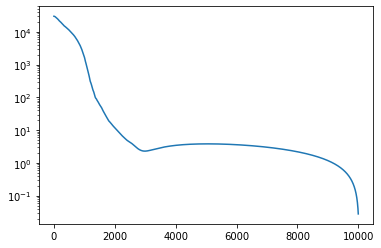

In [40]:
plt.semilogy(np.array(losses_fgm) - losses_fgm[-1] * .999)

In [102]:
losses_gm = [f(x0)]
time_gm = [0]

optimizer = GM(L, grad_f, x0)

for _ in range(10000):
    dt, x = optimizer.step()
    
    losses_gm.append(f(x))
    print(losses_gm[-1])
    time_gm.append(time_gm[-1] + dt)

29948.53134226366
29944.1218885147
29939.71243491001
29935.302981449593
29930.89352813341
29926.484074961532
29922.074621933898
29917.665169050568
29913.255716311523
29908.84626371665
29904.436811266038
29900.027358959767
29895.61790679776
29891.208454779913
29886.799002906457
29882.38955117717
29877.980099592238
29873.57064815153
29869.161196855133
29864.751745702913
29860.342294695023
29855.932843831317
29851.523393112016
29847.11394253688
29842.704492106055
29838.295041819427
29833.885591677135
29829.476141679108
29825.066691825275
29820.657242115718
29816.247792550475
29811.838343129526
29807.428893852823
29803.019444720336
29798.60999573213
29794.20054688826
29789.791098188565
29785.38164963315
29780.972201222037
29776.56275295517
29772.15330483258
29767.74385685421
29763.334409020124
29758.92496133031
29754.515513784765
29750.106066383516
29745.696619126487
29741.287172013792
29736.877725045288
29732.46827822111
29728.05883154113
29723.649385005403
29719.23993861408
29714.8304923

27995.157455447188
27990.74806560746
27986.338675912004
27981.929286360817
27977.519896953883
27973.11050769123
27968.701118572826
27964.291729598768
27959.882340768865
27955.47295208327
27951.063563541928
27946.65417514489
27942.244786892068
27937.835398783536
27933.42601081928
27929.016622999214
27924.607235323478
27920.197847791977
27915.78846040478
27911.379073161846
27906.96968606314
27902.560299108693
27898.150912298544
27893.74152563262
27889.33213911098
27884.92275273359
27880.51336650049
27876.103980411666
27871.69459446706
27867.28520866675
27862.87582301064
27858.46643749888
27854.057052131313
27849.647666908102
27845.238281829035
27840.82889689436
27836.41951210386
27832.01012745765
27827.60074295569
27823.191358597975
27818.7819743846
27814.37259031544
27809.963206390534
27805.553822609923
27801.144438973504
27796.735055481447
27792.325672133622
27787.916288930028
27783.50690587065
27779.097522955657
27774.688140184855
27770.278757558368
27765.869375076134
27761.4599927381

26215.409010144896
26213.150708038145
26210.892406005292
26208.634104046334
26206.37580216126
26204.11750035006
26201.859198612747
26199.600896949327
26197.342595359776
26195.084293844116
26192.825992402344
26190.56769103446
26188.309389740443
26186.051088520333
26183.792787374074
26181.534486301673
26179.276185303203
26177.01788437858
26174.759583527928
26172.50128275107
26170.24298204812
26167.98468141907
26165.726380863878
26163.46808038255
26161.20977997515
26158.951479641633
26156.693179381982
26154.434879196186
26152.176579084316
26149.918279046313
26147.659979082207
26145.401679191957
26143.14337937558
26140.88507963314
26138.62677996454
26136.3684803698
26134.110180848984
26131.851881402054
26129.593582029018
26127.33528272983
26125.07698350453
26122.81868435312
26120.560385275632
26118.302086271975
26116.043787342205
26113.785488486323
26111.527189704342
26109.268890996238
26107.010592362047
26104.752293801666
26102.493995315166
26100.23569690263
26097.977398563926
26095.71910

25201.43879505209
25199.18052611869
25196.9222572591
25194.66398847338
25192.40571976161
25190.14745112365
25187.88918255962
25185.630914069447
25183.372645653162
25181.114377310772
25178.85610904228
25176.59784084762
25174.339572726887
25172.081304680003
25169.82303670701
25167.564768807948
25165.30650098273
25163.04823323137
25160.7899655539
25158.531697950304
25156.27343042063
25154.01516296484
25151.75689558288
25149.49862827486
25147.240361040676
25144.982093880404
25142.723826794012
25140.46555978144
25138.20729284284
25135.949025978072
25133.690759187226
25131.43249247023
25129.174225827108
25126.91595925788
25124.657692762547
25122.399426341064
25120.141159993495
25117.88289371981
25115.624627519977
25113.366361394073
25111.108095341995
25108.84982936383
25106.591563459544
25104.333297629135
25102.075031872602
25099.81676618996
25097.558500581203
25095.300235046332
25093.04196958535
25090.783704198264
25088.525438884993
25086.26717364565
25084.00890848019
25081.750643388605
250

24182.96700322613
24180.708767613334
24178.45053207444
24176.19229660939
24173.934061218253
24171.675825900973
24169.417590657573
24167.159355488053
24164.901120392446
24162.642885370693
24160.384650422806
24158.12641554881
24155.868180748745
24153.609946022527
24151.351711370186
24149.093476791688
24146.835242287118
24144.577007856413
24142.318773499595
24140.060539216654
24137.80230500762
24135.54407087246
24133.285836811156
24131.02760282375
24128.76936891023
24126.511135070563
24124.252901304793
24121.994667612886
24119.736433994873
24117.478200450794
24115.219966980527
24112.96173358416
24110.703500261698
24108.44526701309
24106.187033838407
24103.928800737576
24101.670567710604
24099.41233475754
24097.154101878332
24094.89586907304
24092.63763634161
24090.379403684026
24088.121171100374
24085.862938590588
24083.604706154656
24081.34647379266
24079.08824150453
24076.83000929025
24074.571777149868
24072.31354508334
24070.055313090743
24067.797081172026
24065.53884932718
24063.28061

23166.768441296015
23164.510238929597
23162.25203663707
23159.99383441842
23157.73563227369
23155.477430202794
23153.219228205784
23150.961026282654
23148.702824433407
23146.44462265805
23144.18642095655
23141.928219328976
23139.670017775232
23137.411816295404
23135.153614889434
23132.89541355736
23130.637212299163
23128.379011114856
23126.120810004417
23123.862608967833
23121.60440800518
23119.346207116367
23117.088006301437
23114.82980556042
23112.571604893277
23110.313404299977
23108.05520378058
23105.797003335054
23103.538802963452
23101.280602665684
23099.02240244182
23096.764202291797
23094.50600221569
23092.24780221348
23089.989602285106
23087.731402430614
23085.473202650024
23083.215002943336
23080.956803310517
23078.698603751553
23076.440404266483
23074.18220485531
23071.92400551799
23069.66580625455
23067.40760706501
23065.149407949335
23062.891208907535
23060.633009939622
23058.374811045585
23056.116612225473
23053.858413479167
23051.600214806796
23049.342016208306
23047.083

22410.01679744943
22408.519678053508
22407.02255870658
22405.525439408644
22404.028320159658
22402.531200959675
22401.03408180867
22399.536962706614
22398.03984365358
22396.5427246495
22395.045605694395
22393.54848678826
22392.051367931115
22390.554249122943
22389.057130363773
22387.560011653557
22386.06289299235
22384.5657743801
22383.068655816816
22381.571537302527
22380.0744188372
22378.577300420897
22377.080182053527
22375.583063735154
22374.085945465747
22372.588827245363
22371.091709073917
22369.594590951423
22368.09747287795
22366.60035485345
22365.10323687795
22363.606118951382
22362.109001073815
22360.61188324525
22359.11476546565
22357.617647735005
22356.120530053333
22354.623412420682
22353.126294836973
22351.629177302257
22350.132059816522
22348.634942379747
22347.137824991994
22345.64070765319
22344.14359036336
22342.64647312249
22341.149355930655
22339.652238787745
22338.155121693846
22336.658004648958
22335.16088765296
22333.663770706007
22332.16665380802
22330.669536959

21919.934906147777
21918.99734438111
21918.05978264512
21917.122220939775
21916.18465926512
21915.24709762111
21914.309536007815
21913.371974425154
21912.43441287317
21911.496851351858
21910.559289861223
21909.621728401256
21908.684166971976
21907.746605573346
21906.80904420537
21905.871482868108
21904.933921561485
21903.99636028554
21903.058799040293
21902.12123782568
21901.183676641744
21900.246115488488
21899.308554365904
21898.37099327397
21897.43343221273
21896.495871182164
21895.558310182252
21894.62074921302
21893.683188274452
21892.745627366563
21891.808066489357
21890.870505642797
21889.932944826927
21888.995384041707
21888.057823287156
21887.1202625633
21886.182701870104
21885.245141207582
21884.307580575718
21883.370019974547
21882.43245940404
21881.49489886419
21880.557338355015
21879.619777876513
21878.68221742869
21877.744657011524
21876.80709662503
21875.869536269227
21874.93197594409
21873.994415649577
21873.056855385796
21872.119295152646
21871.1817349502
21870.2441747

21498.035209650196
21497.09766168529
21496.160113751073
21495.222565847507
21494.285017974635
21493.34747013243
21492.4099223209
21491.47237454
21490.534826789823
21489.597279070287
21488.65973138143
21487.72218372324
21486.78463609572
21485.847088498864
21484.909540932706
21483.971993397183
21483.034445892343
21482.096898418178
21481.159350974685
21480.22180356186
21479.28425617972
21478.34670882823
21477.409161507432
21476.471614217266
21475.534066957815
21474.596519729006
21473.658972530855
21472.7214253634
21471.78387822661
21470.84633112049
21469.908784045063
21468.97123700028
21468.033689986158
21467.09614300273
21466.158596049958
21465.221049127853
21464.28350223642
21463.345955375666
21462.40840854557
21461.470861746155
21460.533314977398
21459.59576823933
21458.65822153194
21457.720674855198
21456.783128209114
21455.845581593738
21454.908035009023
21453.97048845496
21453.032941931593
21452.095395438868
21451.15784897683
21450.220302545466
21449.28275614475
21448.345209774725
2

21075.204189755543
21074.266655622934
21073.329121521012
21072.391587449732
21071.454053409176
21070.51651939922
21069.578985419987
21068.641451471412
21067.703917553506
21066.76638366628
21065.828849809706
21064.891315983805
21063.95378218858
21063.016248424017
21062.078714690124
21061.141180986917
21060.203647314338
21059.26611367248
21058.32858006129
21057.39104648073
21056.453512930882
21055.515979411677
21054.578445923147
21053.640912465286
21052.703379038117
21051.76584564158
21050.828312275735
21049.89077894055
21048.953245636043
21048.015712362212
21047.078179119064
21046.14064590654
21045.20311272474
21044.26557957356
21043.328046453105
21042.39051336327
21041.45298030412
21040.515447275644
21039.57791427783
21038.640381310706
21037.702848374232
21036.765315468452
21035.827782593326
21034.890249748853
21033.952716935073
21033.015184151955
21032.077651399508
21031.140118677733
21030.202585986633
21029.26505332619
21028.327520696428
21027.38998809733
21026.452455528928
21025.514

20654.25444888253
20653.316928520726
20652.37940818959
20651.441887889127
20650.504367619345
20649.566847380214
20648.62932717176
20647.69180699398
20646.754286846866
20645.8167667304
20644.879246644647
20643.941726589528
20643.00420656509
20642.066686571325
20641.129166608218
20640.191646675798
20639.254126774053
20638.316606902983
20637.379087062545
20636.441567252783
20635.504047473714
20634.566527725307
20633.62900800756
20632.69148832049
20631.753968664092
20630.816449038364
20629.878929443308
20628.941409878906
20628.003890345193
20627.066370842134
20626.128851369755
20625.19133192803
20624.253812517
20623.316293136635
20622.378773786942
20621.4412544679
20620.503735179544
20619.566215921837
20618.628696694825
20617.691177498462
20616.75365833278
20615.816139197766
20614.8786200934
20613.941101019747
20613.003581976755
20612.06606296441
20611.12854398273
20610.19102503174
20609.25350611141
20608.315987221766
20607.37846836277
20606.44094953444
20605.503430736804
20604.56591196984

20232.373384470247
20231.435877909757
20230.498371379927
20229.560864880772
20228.62335841228
20227.685851974456
20226.74834556732
20225.810839190828
20224.873332845025
20223.935826529876
20222.99832024542
20222.06081399161
20221.123307768463
20220.18580157602
20219.248295414218
20218.31078928308
20217.373283182627
20216.435777112853
20215.498271073735
20214.56076506529
20213.623259087508
20212.68575314039
20211.748247223968
20210.810741338177
20209.8732354831
20208.93572965867
20207.998223864906
20207.06071810182
20206.12321236942
20205.185706667708
20204.2482009967
20203.310695356442
20202.373189747064
20201.435684168657
20200.498178621645
20199.560673106764
20198.623167625516
20197.685662181026
20196.7481567796
20195.810651434123
20194.873146170976
20193.935641043918
20192.998136162732
20192.060631751512
20191.12312826768
20190.185626644958
20189.2481287894
20188.310638591327
20187.373163990855
20186.435721190304
20185.498343239422
20184.561097501763
20183.62412106628
20182.68769202

19867.287470905474
19866.491084163543
19865.69469744766
19864.898310757835
19864.101924094066
19863.305537456345
19862.509150844664
19861.712764259046
19860.916377699476
19860.11999116596
19859.32360465851
19858.527218177085
19857.73083172172
19856.934445292427
19856.13805888917
19855.34167251196
19854.545286160817
19853.748899835722
19852.95251353667
19852.15612726367
19851.35974101674
19850.563354795842
19849.766968601027
19848.970582432237
19848.174196289492
19847.377810172817
19846.581424082186
19845.785038017602
19844.98865197911
19844.192265966605
19843.3958799802
19842.599494019832
19841.803108085507
19841.006722177262
19840.210336295033
19839.413950438873
19838.617564608758
19837.821178804723
19837.02479302671
19836.228407274764
19835.432021548884
19834.63563584902
19833.839250175235
19833.042864527488
19832.246478905796
19831.450093310155
19830.653707740563
19829.857322197044
19829.060936679554
19828.26455118813
19827.46816572275
19826.671780283432
19825.875394870163
19825.079

19510.50881906372
19509.71244399311
19508.916068948543
19508.119693930043
19507.323318937575
19506.526943971166
19505.730569030817
19504.93419411651
19504.137819228257
19503.341444366062
19502.5450695299
19501.748694719805
19500.952319935768
19500.15594517778
19499.35957044582
19498.563195739935
19497.766821060086
19496.9704464063
19496.174071778583
19495.377697176908
19494.581322601258
19493.78494805169
19492.988573528168
19492.19219903068
19491.39582455927
19490.599450113896
19489.803075694577
19489.006701301285
19488.21032693408
19487.41395259293
19486.617578277815
19485.821203988744
19485.02482972574
19484.228455488777
19483.432081277882
19482.635707093046
19481.83933293424
19481.042958801478
19480.246584694785
19479.45021061413
19478.653836559533
19477.857462531007
19477.061088528506
19476.264714552086
19475.46834060168
19474.67196667736
19473.875592779073
19473.079218906845
19472.28284506066
19471.486471240547
19470.690097446462
19469.89372367845
19469.09734993649
19468.300976220

19152.9390325426
19152.142669169214
19151.346305821895
19150.549942500606
19149.753579205386
19148.95721593621
19148.160852693072
19147.364489476015
19146.568126285
19145.771763120032
19144.975399981115
19144.179036868238
19143.382673781427
19142.586310720675
19141.789947685964
19140.99358467729
19140.197221694678
19139.400858738125
19138.604495807635
19137.808132903177
19137.01177002478
19136.215407172418
19135.419044346138
19134.62268154589
19133.826318771688
19133.02995602354
19132.23359330146
19131.437230605414
19130.640867935428
19129.844505291483
19129.048142673604
19128.251780081777
19127.455417515983
19126.65905497626
19125.86269246258
19125.066329974943
19124.269967513374
19123.473605077852
19122.677242668382
19121.880880284963
19121.084517927586
19120.288155596267
19119.491793291
19118.69543101179
19117.89906875863
19117.102706531514
19116.30634433046
19115.50998215544
19114.713620006485
19113.91725788359
19113.120895786727
19112.32453371592
19111.52817167117
19110.7318096524

18795.374498050078
18794.578146373795
18793.781794723567
18792.98544309939
18792.189091501274
18791.392739929182
18790.596388383176
18789.8000368632
18789.003685369258
18788.207333901402
18787.410982459587
18786.614631043813
18785.818279654108
18785.021928290447
18784.22557695283
18783.429225641255
18782.63287435575
18781.83652309629
18781.04017186288
18780.243820655538
18779.447469474224
18778.65111831896
18777.85476718976
18777.05841608661
18776.26206500953
18775.46571395846
18774.669362933473
18773.87301193452
18773.076660961622
18772.28031001478
18771.48395909398
18770.687608199256
18769.891257330564
18769.094906487928
18768.298555671332
18767.502204880795
18766.705854116313
18765.909503377887
18765.113152665508
18764.316801979166
18763.52045131888
18762.72410068465
18761.92775007648
18761.13139949434
18760.335048938272
18759.538698408258
18758.742347904285
18757.945997426366
18757.14964697449
18756.35329654867
18755.556946148907
18754.760595775195
18753.964245427524
18753.16789510

18437.815215526145
18437.01887554682
18436.22253559356
18435.426195666358
18434.629855765208
18433.833515890088
18433.037176041034
18432.240836218014
18431.444496421067
18430.648156650157
18429.851816905313
18429.055477186517
18428.259137493762
18427.462797827062
18426.666458186417
18425.87011857181
18425.073778983253
18424.277439420766
18423.481099884324
18422.684760373933
18421.888420889583
18421.092081431285
18420.295741999067
18419.499402592854
18418.703063212724
18417.90672385864
18417.110384530595
18416.31404522861
18415.51770595268
18414.72136670279
18413.925027478945
18413.128688281173
18412.33234910944
18411.53600996376
18410.739670844134
18409.943331750546
18409.146992683032
18408.35065364155
18407.554314626133
18406.757975636745
18405.961636673423
18405.165297736155
18404.368958824933
18403.57261993976
18402.776281080638
18401.979942247566
18401.18360344055
18400.387264659592
18399.59092590467
18398.794587175806
18397.998248472995
18397.201909796222
18396.405571145508
18395.

18081.057513225307
18080.261184921863
18079.464856648752
18078.668528409617
18077.87220021117
18077.07587206576
18076.279543996254
18075.48321604483
18074.686888289314
18073.890560873424
18073.094234062417
18072.297908345965
18071.501584627953
18070.70526457684
18069.90895127217
18069.112650397674
18068.31637244153
18067.520136751606
18066.723978999602
18065.927964884588
18065.132215176636
18064.33695109149
18063.542575185624
18062.749811214428
18061.959931791607
18061.175084898467
18060.39863294298
18059.63515120308
18058.889366270025
18058.1636281425
18057.455579161164
18056.759171986727
18056.06846907184
18055.37993968862
18054.69210083484
18054.00445783882
18053.316867041875
18052.62928975796
18051.94171594778
18051.254143044145
18050.566570391675
18049.87899782177
18049.1914252905
18048.503852786198
18047.81628030565
18047.128707847976
18046.44113541291
18045.75356300035
18045.065990610336
18044.3784182428
18043.69084589774
18043.00327357518
18042.315701275136
18041.628128997567
1

17789.841034448575
17789.23108968224
17788.62114493586
17788.01120020944
17787.40125550297
17786.791310816443
17786.181366149878
17785.571421503257
17784.9614768766
17784.35153226988
17783.741587683126
17783.13164311633
17782.52169856948
17781.91175404257
17781.301809535613
17780.691865048626
17780.08192058158
17779.471976134497
17778.86203170735
17778.252087300163
17777.64214291294
17777.032198545643
17776.42225419833
17775.81230987095
17775.202365563542
17774.59242127606
17773.982477008536
17773.372532760975
17772.762588533365
17772.152644325695
17771.542700137998
17770.93275597024
17770.322811822432
17769.71286769458
17769.102923586684
17768.49297949873
17767.88303543075
17767.273091382714
17766.66314735462
17766.053203346488
17765.443259358304
17764.833315390075
17764.22337144179
17763.613427513472
17763.003483605095
17762.393539716675
17761.78359584821
17761.173651999696
17760.563708171125
17759.95376436251
17759.343820573853
17758.733876805145
17758.123933056395
17757.51398932759

17515.367905294177
17514.757969506434
17514.14803373862
17513.538097990768
17512.92816226288
17512.318226554933
17511.708290866944
17511.098355198894
17510.48841955081
17509.878483922676
17509.2685483145
17508.658612726264
17508.048677157978
17507.43874160965
17506.828806081274
17506.21887057286
17505.60893508439
17504.99899961587
17504.38906416731
17503.7791287387
17503.16919333004
17502.559257941328
17501.949322572575
17501.339387223765
17500.729451894917
17500.11951658602
17499.509581297072
17498.89964602807
17498.28971077903
17497.679775549946
17497.0698403408
17496.45990515161
17495.849969982377
17495.240034833103
17494.630099703772
17494.020164594407
17493.410229504974
17492.800294435507
17492.190359385986
17491.580424356413
17490.9704893468
17490.36055435714
17489.750619387414
17489.140684437665
17488.530749507856
17487.920814598012
17487.310879708104
17486.700944838158
17486.091009988162
17485.48107515811
17484.87114034802
17484.261205557883
17483.65127078769
17483.04133603746


17242.118670154658
17241.508743305476
17240.898816476238
17240.288889666965
17239.67896287764
17239.069036108252
17238.45910935883
17237.84918262937
17237.239255919845
17236.62932923028
17236.019402560654
17235.40947591101
17234.79954928129
17234.18962267153
17233.579696081728
17232.96976951187
17232.35984296196
17231.749916432018
17231.13998992202
17230.530063431965
17229.920136961864
17229.310210511725
17228.700284081537
17228.090357671288
17227.48043128101
17226.870504910672
17226.260578560283
17225.65065222986
17225.040725919385
17224.430799628855
17223.820873358287
17223.210947107666
17222.60102087699
17221.99109466628
17221.38116847551
17220.77124230469
17220.161316153823
17219.551390022927
17218.941463911964
17218.331537820955
17217.721611749897
17217.11168569879
17216.501759667648
17215.891833656446
17215.281907665198
17214.67198169391
17214.062055742575
17213.452129811176
17212.842203899738
17212.232278008258
17211.62235213671
17211.012426285128
17210.4025004535
17209.79257464

16968.873439471663
16968.263521560933
16967.653603670184
16967.043685799363
16966.433767948503
16965.823850117606
16965.213932306648
16964.60401451563
16963.994096744576
16963.384178993478
16962.77426126233
16962.164343551132
16961.55442585989
16960.944508188593
16960.33459053725
16959.72467290586
16959.11475529442
16958.504837702934
16957.894920131403
16957.28500257981
16956.67508504818
16956.0651675365
16955.455250044783
16954.845332573004
16954.23541512117
16953.62549768931
16953.015580277384
16952.405662885416
16951.795745513413
16951.185828161342
16950.575910829222
16949.965993517068
16949.35607622485
16948.746158952585
16948.136241700286
16947.52632446793
16946.91640725553
16946.306490063092
16945.696572890578
16945.086655738043
16944.476738605437
16943.86682149279
16943.256904400103
16942.646987327367
16942.03707027458
16941.42715324174
16940.817236228853
16940.20731923592
16939.59740226294
16938.98748530991
16938.37756837683
16937.76765146372
16937.157734570534
16936.5478176973

16695.02230422718
16694.41239527477
16693.802486342327
16693.192577429832
16692.582668537296
16691.972759664688
16691.36285081206
16690.75294197937
16690.143033166634
16689.533124373855
16688.923215601015
16688.313306848126
16687.703398115205
16687.09348940223
16686.48358070919
16685.873672036116
16685.26376338299
16684.653854749828
16684.043946136604
16683.43403754333
16682.82412897001
16682.21422041665
16681.60431188323
16680.994403369772
16680.384494876253
16679.774586402695
16679.164677949087
16678.55476951543
16677.944861101725
16677.334952707966
16676.725044334158
16676.115135980315
16675.505227646427
16674.895319332467
16674.28541103846
16673.675502764425
16673.06559451034
16672.4556862762
16671.845778062
16671.235869867767
16670.62596169348
16670.016053539148
16669.406145404762
16668.79623729034
16668.186329195847
16667.576421121317
16666.966513066745
16666.356605032117
16665.746697017446
16665.136789022727
16664.52688104796
16663.91697309313
16663.307065158264
16662.6971572433

In [92]:
grad_f(None, zero_grad=True)

In [95]:
losses_cgm = [f(x0)]
time_cgm = [0]

optimizer = CGM(L_, grad_f, x0)

for _ in range(10000):
    dt, x = optimizer.step()
    
    losses_cgm.append(f(x))
    time_cgm.append(time_cgm[-1] + dt)

<ipython-input-94-37d2326e402d>:42: RuntimeWarning: divide by zero encountered in log
  expAx[rnz[0]] = np.power(np.exp(np.log(expAx[rnz[0]]) * gamma + r[rnz] - maxAx), 1/gamma)


In [33]:
losses_fcgm = [f(x0)]
time_fcgm = [0]

optimizer = FCGM([Li + mu for Li in L_], grad_f, x0)

for _ in range(10000):
    dt, x = optimizer.step()
    
    losses_fcgm.append(f(x))
    time_fcgm.append(time_fcgm[-1] + dt)

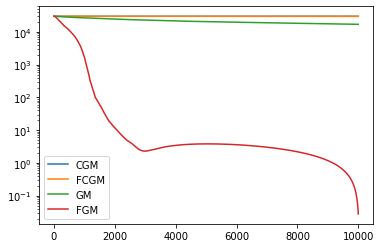

In [97]:
plt.semilogy(np.array(losses_cgm) - losses_fgm[-1]*0.999, label="CGM")
plt.semilogy(np.array(losses_fcgm) - losses_fgm[-1]*0.999, label="FCGM")
plt.semilogy(np.array(losses_gm) - losses_fgm[-1]*0.999, label="GM")
plt.semilogy(np.array(losses_fgm) - losses_fgm[-1]*0.999, label="FGM")
plt.legend()

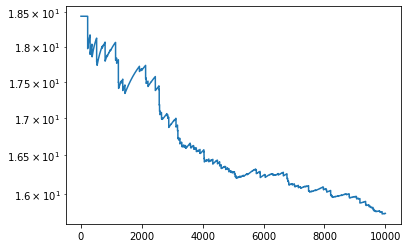

In [20]:
plt.semilogy(np.array(losses_fcgm) - losses_fgm[-1]*0.999, label="FCGM")

In [181]:
losses_um = [f(x0)]
time_um = [0]

optimizer = UM(L * 0.05, L_, grad_f, subsolver=GM, x0=x0, component=False)

for _ in range(200):
    dts, xs = optimizer.step(t=1000)
    
    losses_um += [f(x) for x in xs]
    time_um += (time_um[-1] + dts).tolist()

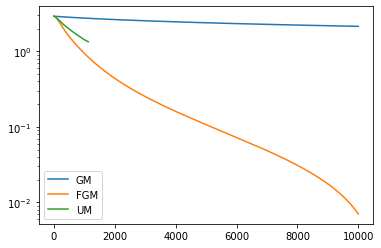

In [182]:
plt.semilogy(np.array(losses_gm) - losses_fgm[-1]*0.999, label="GM")
plt.semilogy(np.array(losses_fgm) - losses_fgm[-1]*0.999, label="FGM")
plt.semilogy(np.array(losses_um) - losses_fgm[-1]*0.999, label="UM")
plt.legend()

In [109]:
grad_f(None, zero_grad=True)

In [119]:
losses_umc = [f(x0)]
time_umc = [0]

optimizer = UM(L * 0.01, L_, grad_f, subsolver=CGM, x0=x0)

for _ in range(10000):
    dts, xs = optimizer.step(t=10)
    
    losses_umc += [f(x) for x in xs]
    time_umc += (time_umc[-1] + dts).tolist()

<ipython-input-94-37d2326e402d>:42: RuntimeWarning: divide by zero encountered in log
  expAx[rnz[0]] = np.power(np.exp(np.log(expAx[rnz[0]]) * gamma + r[rnz] - maxAx), 1/gamma)


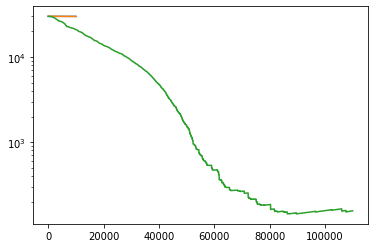

In [120]:
plt.semilogy(np.array(losses_cgm) - losses_fgm[-1]*0.999, label="CGM")
plt.semilogy(np.array(losses_fcgm) - losses_fgm[-1]*0.999, label="FCGM")
plt.semilogy(np.array(losses_umc) - losses_fgm[-1]*0.999, label="UMC")

In [121]:
f_opt = losses_fgm[-1] * 0.999

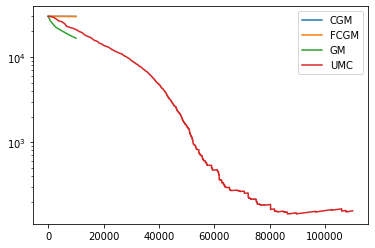

In [122]:
plt.semilogy(np.array(losses_cgm) - f_opt, label="CGM")
plt.semilogy(np.array(losses_fcgm) - f_opt, label="FCGM")
# plt.semilogy(np.array(losses_cgm)[::n][:100] - losses_fgm[-1]*0.999, label="CGM")
# plt.semilogy(np.array(losses_fcgm)[::n][:100] - losses_fgm[-1]*0.999, label="FCGM")
plt.semilogy(np.array(losses_gm) - f_opt, label="GM")
# plt.semilogy(np.array(losses_fgm) - losses_fgm[-1]*0.999, label="FGM")
plt.semilogy(np.array(losses_umc) - f_opt, label="UMC")
plt.legend()

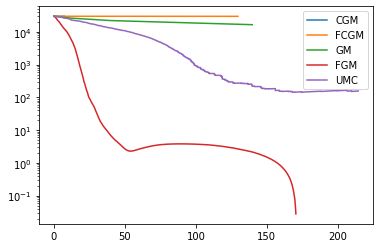

In [123]:
plt.semilogy(time_cgm, np.array(losses_cgm) - f_opt, label="CGM")
plt.semilogy(time_fcgm, np.array(losses_fcgm) - f_opt, label="FCGM")
plt.semilogy(time_gm, np.array(losses_gm) - f_opt, label="GM")
plt.semilogy(time_fgm, np.array(losses_fgm) - f_opt, label="FGM")
plt.semilogy(time_umc, np.array(losses_umc) - f_opt, label="UMC")
plt.legend()